In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
library(keras)
library(tensorflow)
library(reticulate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "jigsaw-train-data-preprocessed-1" "uncased-l12-h768-a12"

In [2]:
reticulate::py_config()

python:         /usr/local/share/.virtualenvs/r-reticulate/bin/python
libpython:      /usr/lib/python3.7/config-3.7m-x86_64-linux-gnu/libpython3.7.so
pythonhome:     /usr/local/share/.virtualenvs/r-reticulate:/usr/local/share/.virtualenvs/r-reticulate
version:        3.7.3 (default, Jan 22 2021, 20:04:44)  [GCC 8.3.0]
numpy:          /usr/local/share/.virtualenvs/r-reticulate/lib/python3.7/site-packages/numpy
numpy_version:  1.18.5
tensorflow:     /usr/local/share/.virtualenvs/r-reticulate/lib/python3.7/site-packages/tensorflow

python versions found: 
 /usr/local/share/.virtualenvs/r-reticulate/bin/python
 /usr/bin/python3
 /usr/bin/python

In [10]:
list.files(path = "../input")

[1] "jigsaw-train-data-preprocessed-1" "uncased-l12-h768-a12"

In [4]:
py_install('keras-bert')
bert=import('keras_bert')
py_module_available('keras_bert')

Using virtual environment '/usr/local/share/.virtualenvs/r-reticulate' ...


[1] TRUE

In [24]:

config_path = file.path('../input/uncased-l12-h768-a12/uncased_L-12_H-768_A-12/bert_config.json')
checkpoint_path = file.path('../input/uncased-l12-h768-a12/uncased_L-12_H-768_A-12/bert_model.ckpt')
vocab_path = file.path('../input/uncased-l12-h768-a12/uncased_L-12_H-768_A-12/vocab.txt')

# Create Dataset

In [25]:
k_bert = import('keras_bert')
token_dict = k_bert$load_vocabulary(vocab_path)
tokenizer = k_bert$Tokenizer(token_dict)

In [26]:
seq_length = 50L
bch_size = 70
epochs = 1
learning_rate = 1e-4

DATA_COLUMN = 'comment_text'
LABEL_COLUMN = 'target'

In [27]:
model = k_bert$load_trained_model_from_checkpoint(
  config_path,
  checkpoint_path,
  training=T,
  trainable=T,
  seq_len=seq_length)

In [28]:
# tokenize text
tokenize_fun = function(dataset) {
  c(indices, target, segments) %<-% list(list(),list(),list())
  for ( i in 1:nrow(dataset)) {
    c(indices_tok, segments_tok) %<-% tokenizer$encode(dataset[[DATA_COLUMN]][i], 
                                                       max_len=seq_length)
    indices = indices %>% append(list(as.matrix(indices_tok)))
    target = target %>% append(dataset[[LABEL_COLUMN]][i])
    segments = segments %>% append(list(as.matrix(segments_tok)))
  }
  return(list(indices,segments, target))
}
# read data
dt_data = function(dir, rows_to_read){
  data = data.table::fread(dir, nrows=rows_to_read)
  c(x_train, x_segment, y_train) %<-% tokenize_fun(data)
  return(list(x_train, x_segment, y_train))
}

In [64]:
c(x_train,x_segment, y_train) %<-% 
dt_data('../input/jigsaw-train-data-preprocessed-1/train_preprocessed_1.csv',1000)

In [65]:
train = do.call(cbind,x_train) %>% t()
segments = do.call(cbind,x_segment) %>% t()
targets = do.call(cbind,y_train) %>% t()

concat = c(list(train ),list(segments))

In [66]:
#Calculate decay and warmup steps
c(decay_steps, warmup_steps) %<-% k_bert$calc_train_steps(
  targets %>% length(),
  batch_size=bch_size,
  epochs=epochs
)

In [67]:
#Determine inputs and outputs, then concatenate them
library(keras)

input_1 = get_layer(model,name = 'Input-Token')$input
input_2 = get_layer(model,name = 'Input-Segment')$input
inputs = list(input_1,input_2)

dense = get_layer(model,name = 'NSP-Dense')$output

outputs = dense %>% layer_dense(units=1L, activation='sigmoid',
                         kernel_initializer=initializer_truncated_normal(stddev = 0.02),
                         name = 'output')

model = keras_model(inputs = inputs,outputs = outputs)


Final epoch (plot to see history):
        loss: 0.3137
    accuracy: 0.7912
    val_loss: 0.2509
val_accuracy: 0.81 

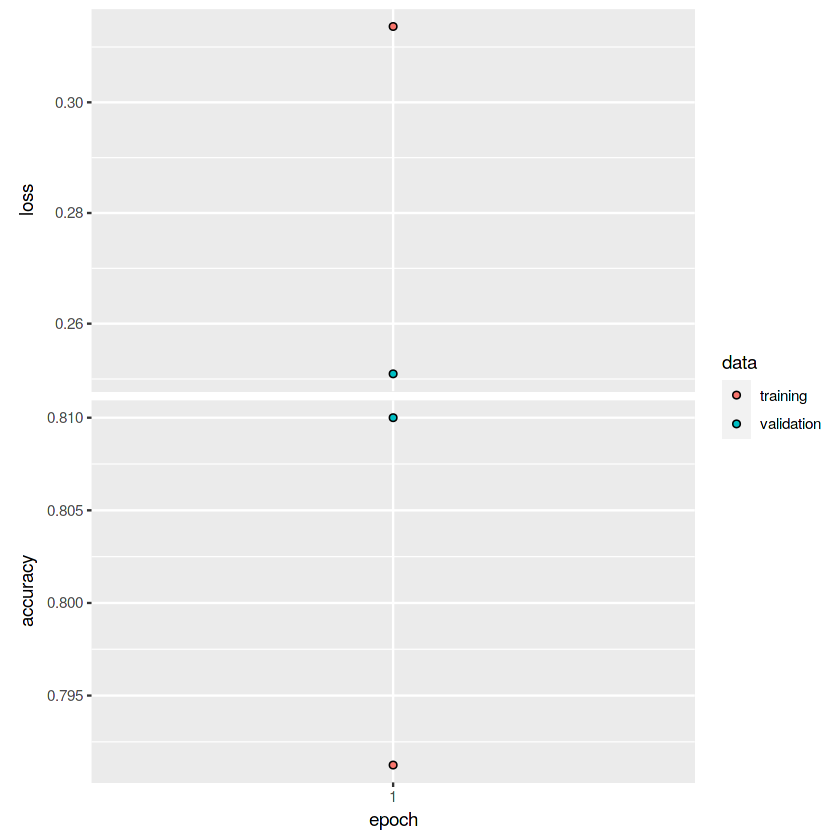

In [68]:
#Compile model and begin training
model %>% compile(
  k_bert$AdamWarmup(decay_steps=decay_steps, 
                    warmup_steps=warmup_steps, 
                    lr=learning_rate),
  loss = 'binary_crossentropy',
  metrics = 'accuracy'
)

history <- model %>% fit(
  concat,
  targets,
  epochs=epochs,
  batch_size=bch_size, validation_split=0.2)
history;plot(history)